### 패키지 설치

In [1]:
!pip install prophet

In [67]:
# train 데이터가 있는 폴더로 변경해주시기 바랍니다.
import os 
os.chdir("C:\\Users\\pc\\Desktop\\UOS")

### 라이브러리 버전

In [68]:
pip list

Package                            Version
---------------------------------- --------------------
absl-py                            1.1.0
alabaster                          0.7.12
anaconda-client                    1.9.0
anaconda-navigator                 2.1.4
anaconda-project                   0.10.1
anyio                              2.2.0
appdirs                            1.4.4
argh                               0.26.2
argon2-cffi                        20.1.0
arrow                              0.13.1
asn1crypto                         1.4.0
astroid                            2.6.6
astropy                            4.3.1
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              21.2.0
autopep8                           1.5.7
Babel                              2.9.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size 

numpy : 1.23.5, pandas: 1.3.4, matplotlib : 3.4.3, Prophet: 1.1.1, scikit-learn: 0.24.2, seaborn: 0.11.2  
warnings는 버전이 따로 명시되어 있지 않습니다.

### os

### 아나콘다 주피터노트북 환경  
### 파이썬 버전: 3.9.7

In [69]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore') 

prophet에서 신뢰구간의 하한과 상한에 해당되는 data를 이상치로 dataframe의 column에 "anomaly"로 한다

### (prophet 기반 anomally detection)

In [70]:
def detect_anomalies_low(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted['yhat_upper'] = forecasted['yhat_upper'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted['yhat_lower'] = forecasted['yhat_lower'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1

    return forecasted

def detect_anomalies_up(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted['yhat_upper'] = forecasted['yhat_upper'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted['yhat_lower'] = forecasted['yhat_lower'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1

    return forecasted


### 기본 prophet setting 

In [71]:
def fit_predict_model(dataframe, interval_width = 0.6, changepoint_range = 0.2):
    m = Prophet(interval_width = interval_width,
               changepoint_range = changepoint_range,
                seasonality_mode='multiplicative')
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

### anomal 적용하고 이상치 제거 된거 시각화를 위한 함수

In [72]:
def get_view(df, target):
    viewd = df[['Date', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()

    print(target)
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.scatterplot(x='Date', y=target, data=viewd)
    plt.show()

In [73]:
train_df = pd.read_csv('./train.csv')
train_df['Date'] = train_df['일시'].astype(str)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df.drop(['일시'], axis = 'columns')
# 21년도 데이터 validation set, 18~20년도 train set 
train_df = train_df[train_df['Date'] < '2021 -01-01'] 
train_df.head()

,광진구,동대문구,성동구,중랑구,Date
0,0.592,0.368,0.580,0.162,2018-01-01
1,0.840,0.614,1.034,0.260,2018-01-02
2,0.828,0.576,0.952,0.288,2018-01-03
3,0.792,0.542,0.914,0.292,2018-01-04
4,0.818,0.602,0.994,0.308,2018-01-05


입력 데이터 생성

광진구


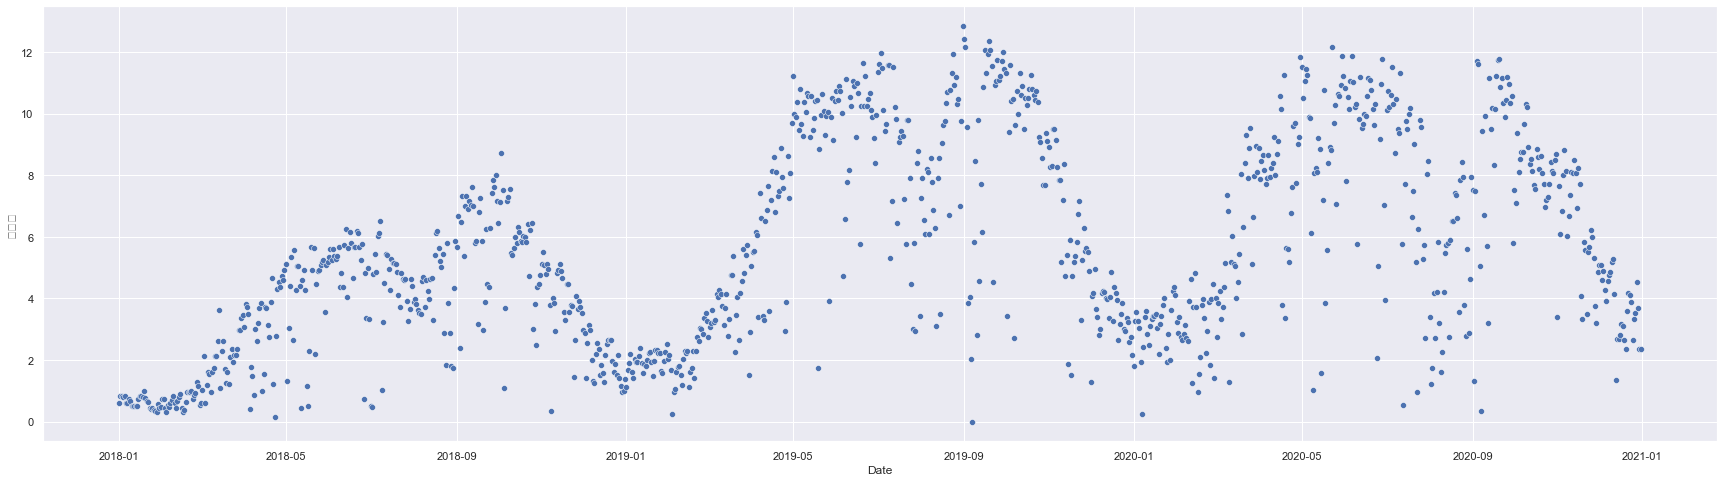

동대문구


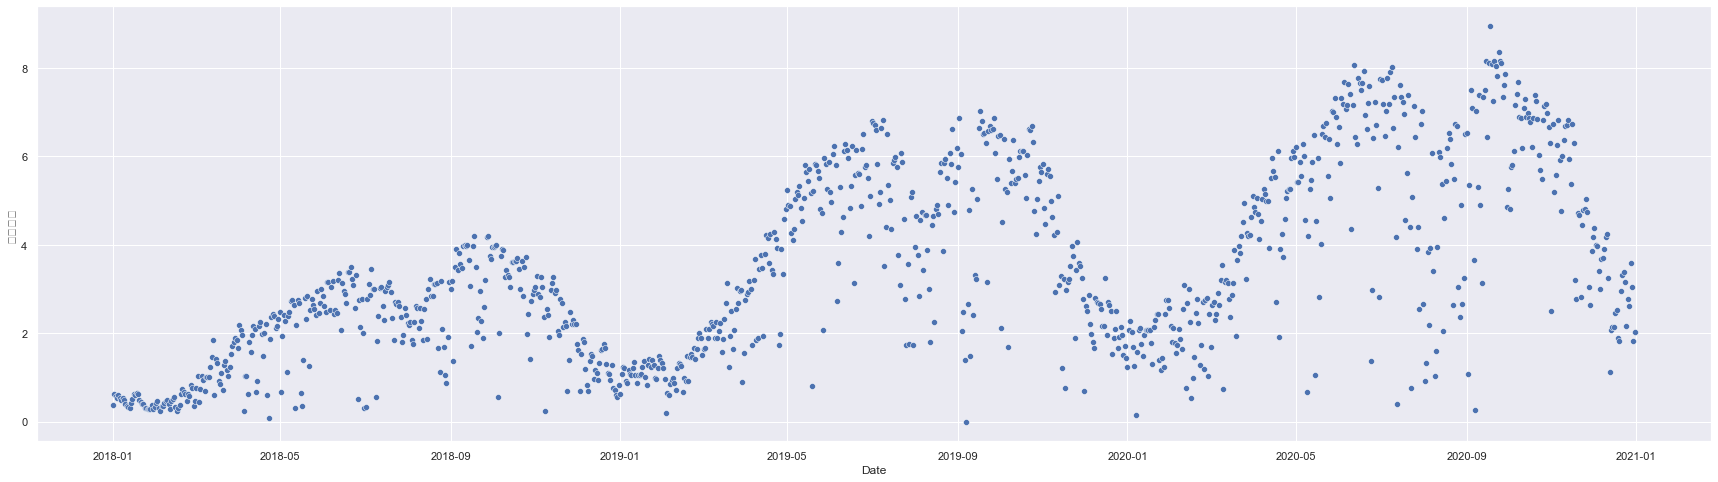

성동구


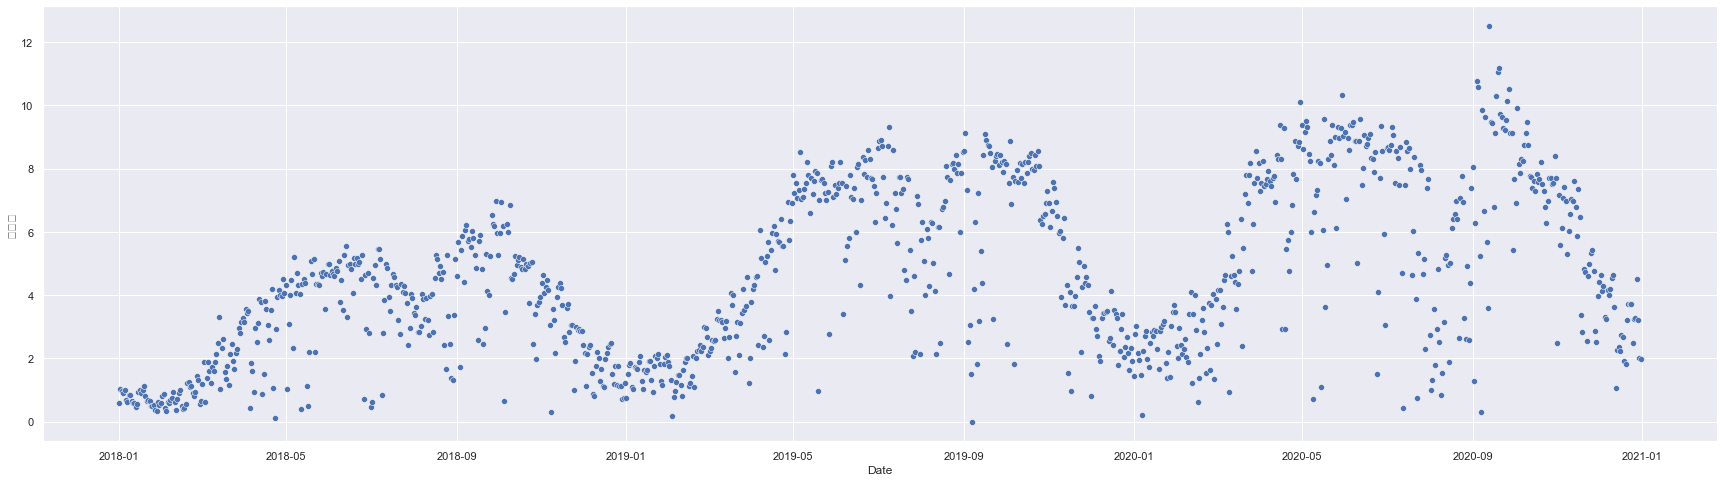

중랑구


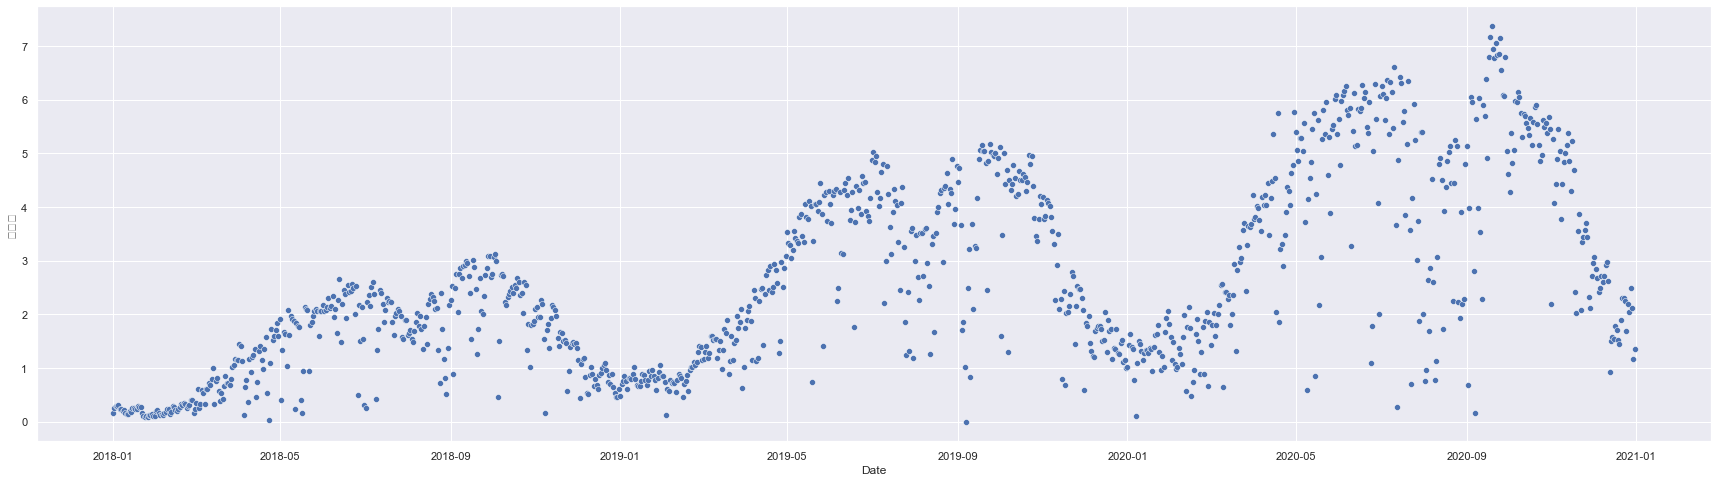

In [74]:
get_view(train_df, '광진구')
get_view(train_df, '동대문구')
get_view(train_df, '성동구')
get_view(train_df, '중랑구')

In [75]:
gj = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['광진구']
})
ddm = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['동대문구']
})
sd = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['성동구']
})
jr = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['중랑구']
})

### raw 데이터를 이용한 예측

In [76]:
gj_model = Prophet(
    yearly_seasonality=2,seasonality_mode='multiplicative', 
    changepoint_range = 0.2, interval_width = 0.6)
ddm_model = Prophet(
    yearly_seasonality=2,seasonality_mode='multiplicative', 
    changepoint_range = 0.2, interval_width = 0.6)
sd_model = Prophet(
    yearly_seasonality=2,seasonality_mode='multiplicative', 
    changepoint_range = 0.2, interval_width = 0.6)
jr_model = Prophet(
    yearly_seasonality=2,seasonality_mode='multiplicative',
    changepoint_range = 0.2, interval_width = 0.6)

gj_model.fit(gj)
ddm_model.fit(ddm)
sd_model.fit(sd)
jr_model.fit(jr)

15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:04 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:04 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:04 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:04 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
dates_ = pd.date_range('2019-1-1','2021-12-31')
last_1year_ = pd.DataFrame(dates_, columns = ['ds'])

In [78]:
gj_forecast = gj_model.predict(last_1year_)
ddm_forecast_ = ddm_model.predict(last_1year_)
fd_orecast_ = sd_model.predict(last_1year_)
jr_forecast_ = jr_model.predict(last_1year_)

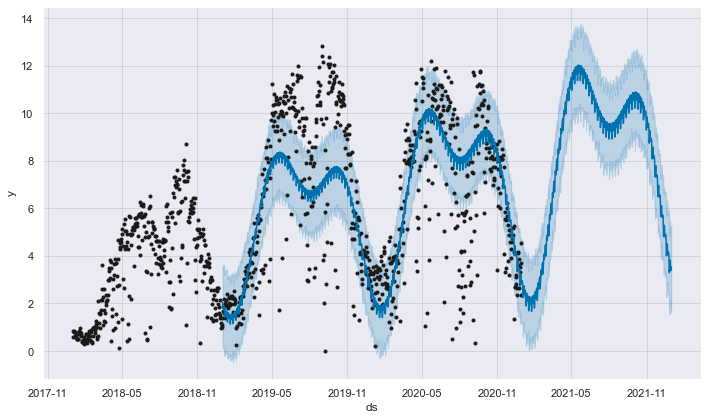

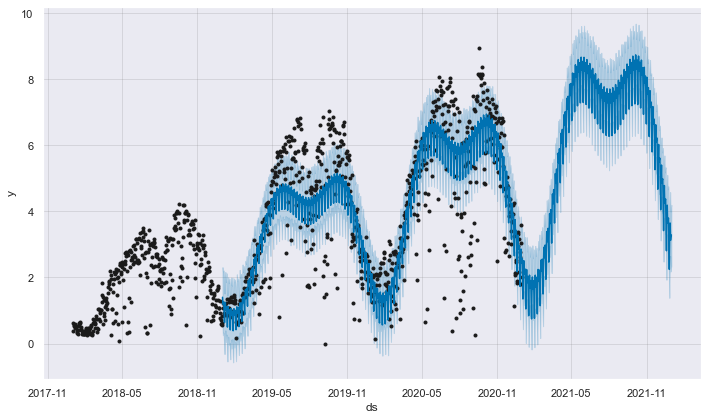

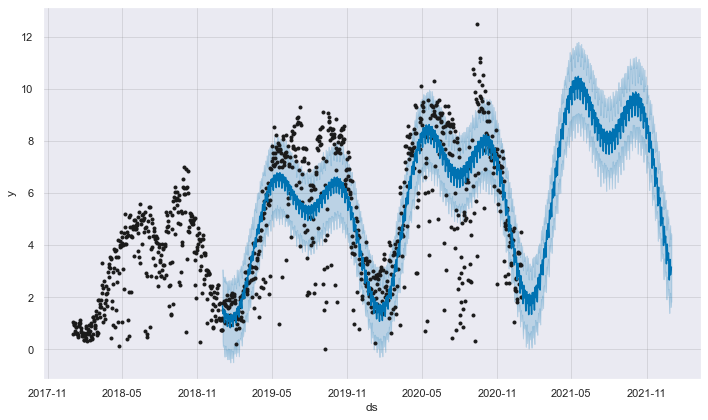

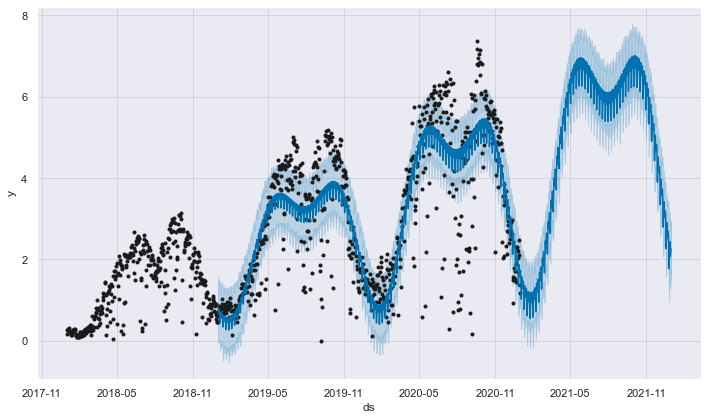

In [79]:
gj_model.plot(gj_forecast)
ddm_model.plot(ddm_forecast_)
sd_model.plot(fd_orecast_)
jr_model.plot(jr_forecast_)
pyplot.show()

raw data로 적합을 했더니 irregular term의 영향으로 오실레이션(진동성)이 크게 느껴지기 때문에 Prophet의 신뢰구간을 이용하여 이상치 탐색후 제거를 하는 과정을 거친다.

### 아래쪽 이상치 제거(1차)

In [80]:
# 첫번째 이상치 제거 interval_width = 0.7로 설정
pred_gj = fit_predict_model(gj, interval_width = 0.7)
pred_gj = detect_anomalies_low(pred_gj)

pred_ddm = fit_predict_model(ddm, interval_width = 0.7)
pred_ddm = detect_anomalies_low(pred_ddm)

pred_sd = fit_predict_model(sd, interval_width = 0.7)
pred_sd = detect_anomalies_low(pred_sd)

pred_jr = fit_predict_model(jr, interval_width = 0.7)
pred_jr = detect_anomalies_low(pred_jr)

15:16:08 - cmdstanpy - INFO - Chain [1] start processing
15:16:09 - cmdstanpy - INFO - Chain [1] done processing
15:16:09 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:10 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing


In [81]:
# 이상치 수 확인하기
gj_anomaly = pred_gj.anomaly == 1
ddm_anomaly = pred_ddm.anomaly == 1
sd_anomaly = pred_sd.anomaly == 1
jr_anomaly = pred_jr.anomaly == 1

print(sum(gj_anomaly), sum(ddm_anomaly), sum(sd_anomaly), sum(jr_anomaly))

128 133 128 115


In [82]:
# 이상치는 결측치로 바꿈.
pred_gj.iloc[gj_anomaly, 5] = np.nan
pred_ddm.iloc[ddm_anomaly, 5] = np.nan
pred_sd.iloc[sd_anomaly, 5] = np.nan
pred_jr.iloc[jr_anomaly, 5] = np.nan

In [83]:
dates = pd.date_range('2018-1-1','2020-12-31')
merge = pd.DataFrame({
    'Date' : dates,
    '광진구' : pred_gj.fact,
    '동대문구' : pred_ddm.fact,
    '성동구' : pred_sd.fact,
    '중랑구' : pred_jr.fact
})

광진구


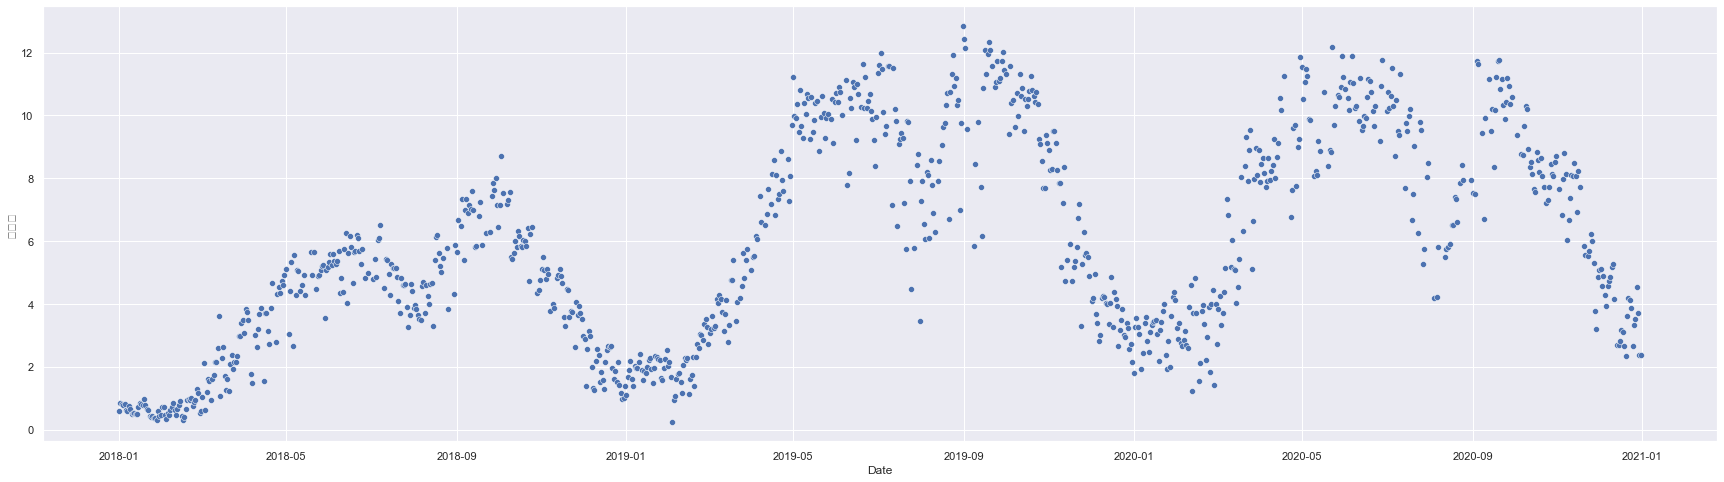

동대문구


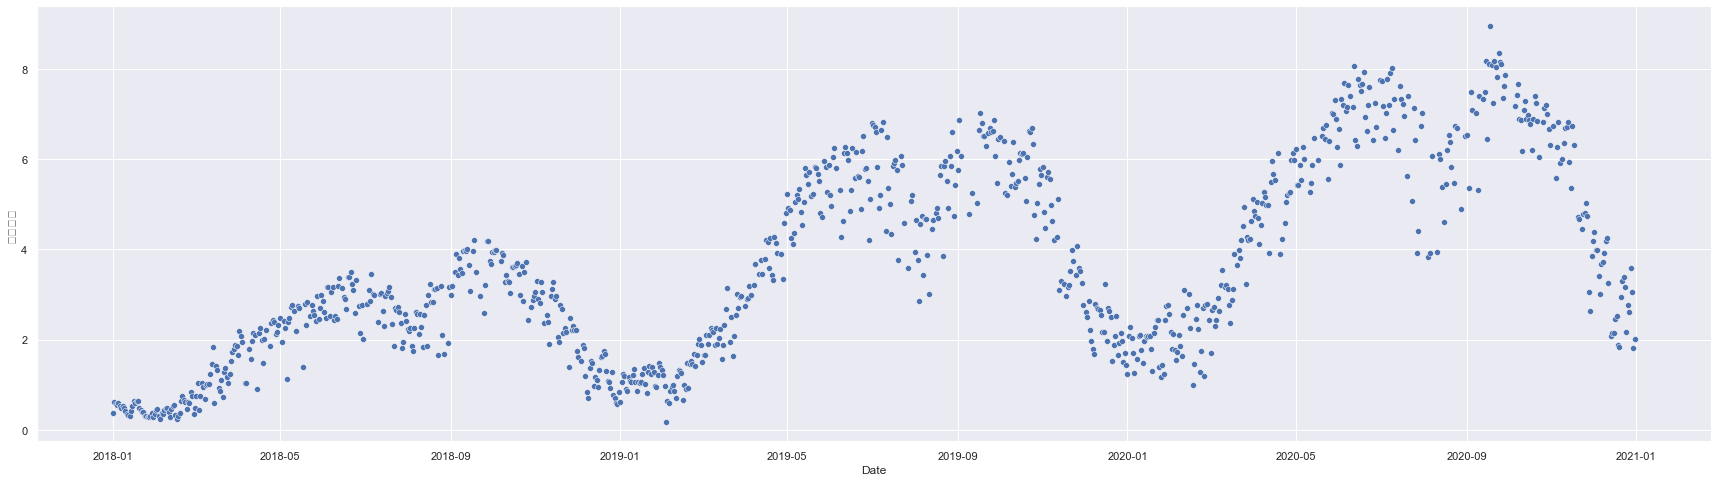

성동구


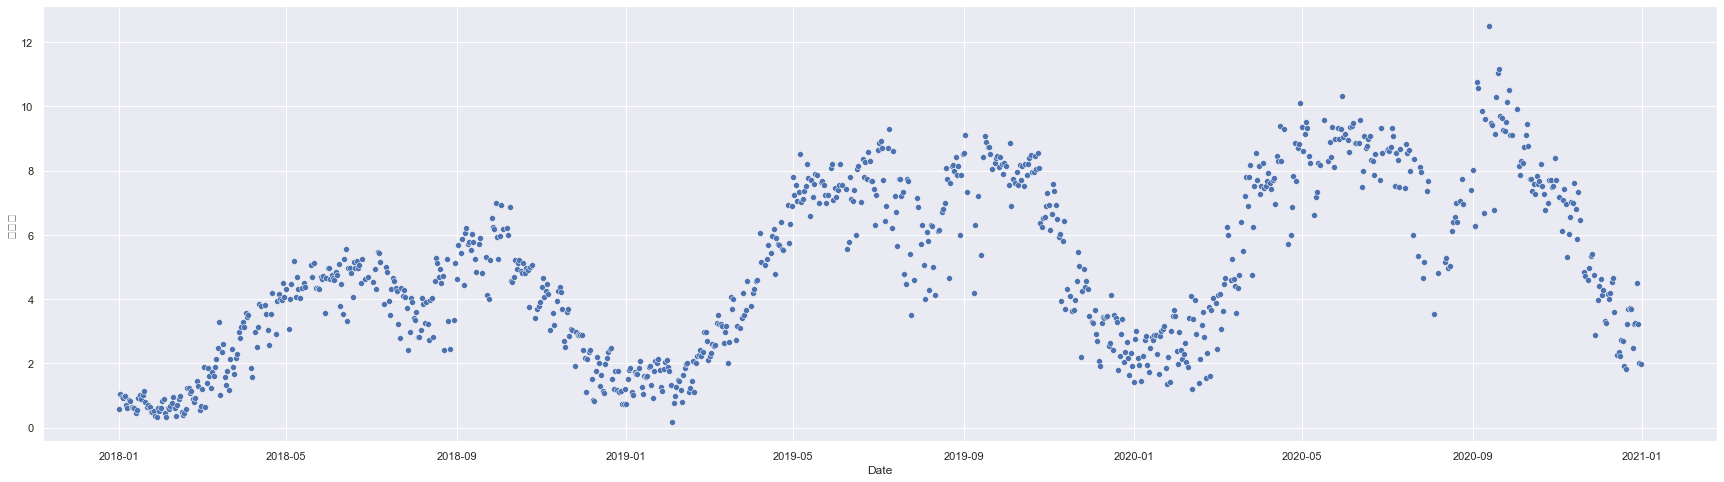

중랑구


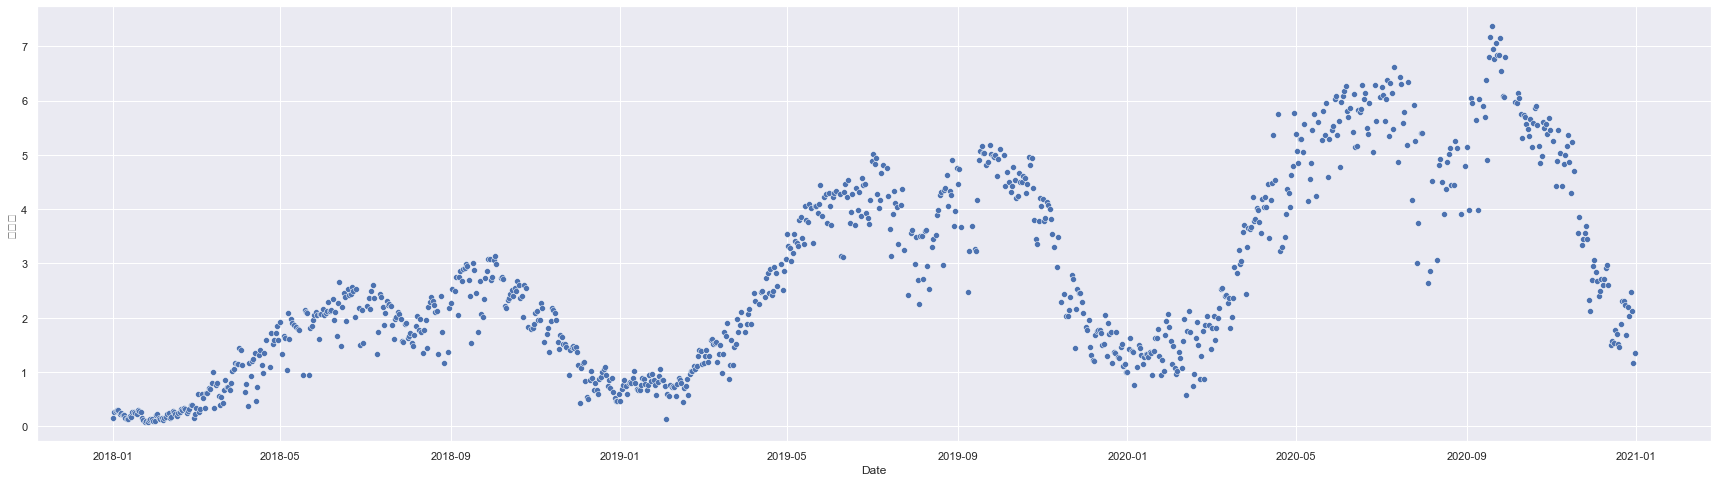

In [84]:
# 아래 부분 이상치가 잘 제거 된 것으로 보임.
get_view(merge, '광진구')
get_view(merge, '동대문구')
get_view(merge, '성동구')
get_view(merge, '중랑구')

In [85]:
gj1 = pd.DataFrame({
    'ds' : pred_gj['ds'],
    'y' : pred_gj['fact']
})
ddm1 = pd.DataFrame({
    'ds' : pred_ddm['ds'],
    'y' : pred_ddm['fact']
})
sd1 = pd.DataFrame({
    'ds' : pred_sd['ds'],
    'y' : pred_sd['fact']
})
jr1 = pd.DataFrame({
    'ds' : pred_jr['ds'],
    'y' : pred_jr['fact']
})

### 아래쪽 이상치 제거하고 모델링을 하고 시각화

In [86]:
gj_model_ = Prophet(
    yearly_seasonality=2,
                    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)
ddm_model_ = Prophet(
    yearly_seasonality=2,
                     seasonality_mode='multiplicative', 
                     changepoint_range = 0.2, interval_width = 0.8)
sd_model_ = Prophet(
    yearly_seasonality=2,
    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)
jr_model_ = Prophet(
    yearly_seasonality=2,
    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)
# 모델 학습
gj_model_.fit(gj1)
ddm_model_.fit(ddm1)
sd_model_.fit(sd1)
jr_model_.fit(jr1)

15:16:14 - cmdstanpy - INFO - Chain [1] start processing
15:16:14 - cmdstanpy - INFO - Chain [1] done processing
15:16:15 - cmdstanpy - INFO - Chain [1] start processing
15:16:15 - cmdstanpy - INFO - Chain [1] done processing
15:16:15 - cmdstanpy - INFO - Chain [1] start processing
15:16:15 - cmdstanpy - INFO - Chain [1] done processing
15:16:15 - cmdstanpy - INFO - Chain [1] start processing
15:16:15 - cmdstanpy - INFO - Chain [1] done processing


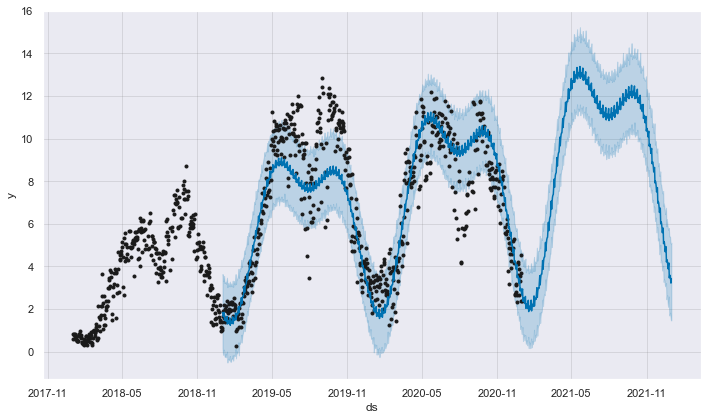

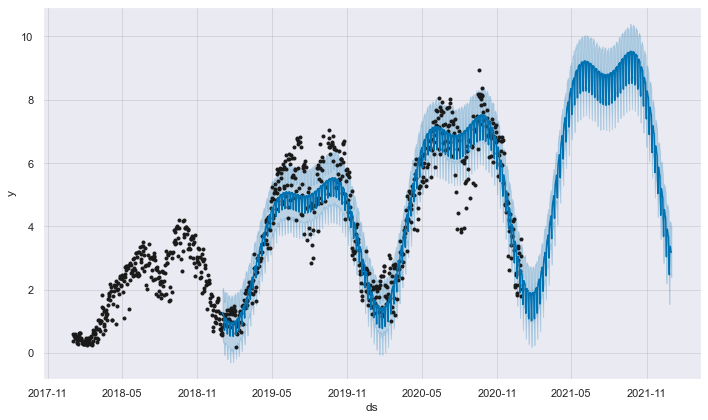

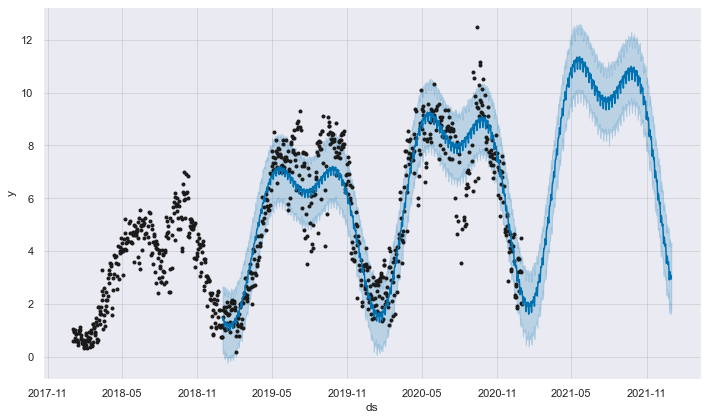

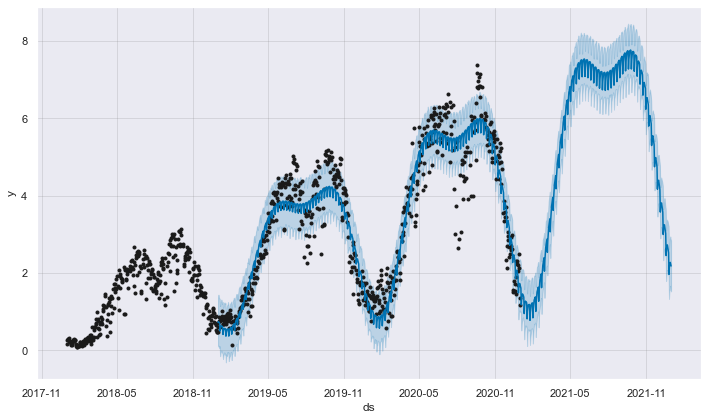

In [87]:
dates_ = pd.date_range('2019-1-1','2021-12-31')
last_1year_ = pd.DataFrame(dates_, columns = ['ds'])

gj_forecast_ = gj_model_.predict(last_1year_)
ddm_forecast_ = ddm_model_.predict(last_1year_)
fd_orecast_ = sd_model_.predict(last_1year_)
jr_forecast_ = jr_model_.predict(last_1year_)

gj_model_.plot(gj_forecast_)
ddm_model_.plot(ddm_forecast_)
sd_model_.plot(fd_orecast_)
jr_model_.plot(jr_forecast_)
pyplot.show()

# raw_data로 prophet보다 fitting이 잘 되는 것 같다. 하지만 오실레이션과
# 위쪽데이터를 전처리 한다면 좀 더 fitting이 잘 될 것 같다. 
# 또한 아래쪽의 이상치가 또 영향을 주는 것 같아보이므로 아래쪽 이상치를 한 번 더 제거
# 해보는 방안도 생각해보았습니다.

### 위쪽 이상치 제거

In [88]:
pred_gj = fit_predict_model(gj1, interval_width = 0.7)
pred_gj = detect_anomalies_up(pred_gj)

pred_ddm = fit_predict_model(ddm1, interval_width = .7)
pred_ddm = detect_anomalies_up(pred_ddm)

pred_sd = fit_predict_model(sd1, interval_width = .7)
pred_sd = detect_anomalies_up(pred_sd)

pred_jr = fit_predict_model(jr1, interval_width = .7)
pred_jr = detect_anomalies_up(pred_jr)

15:16:19 - cmdstanpy - INFO - Chain [1] start processing
15:16:19 - cmdstanpy - INFO - Chain [1] done processing
15:16:20 - cmdstanpy - INFO - Chain [1] start processing
15:16:20 - cmdstanpy - INFO - Chain [1] done processing
15:16:21 - cmdstanpy - INFO - Chain [1] start processing
15:16:21 - cmdstanpy - INFO - Chain [1] done processing
15:16:22 - cmdstanpy - INFO - Chain [1] start processing
15:16:22 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
gj_anomaly = pred_gj.anomaly == 1
ddm_anomaly = pred_ddm.anomaly == 1
sd_anomaly = pred_sd.anomaly == 1
jr_anomaly = pred_jr.anomaly == 1

print(sum(gj_anomaly), sum(ddm_anomaly), sum(sd_anomaly), sum(jr_anomaly))

pred_gj.iloc[gj_anomaly, 5] = np.nan
pred_ddm.iloc[ddm_anomaly, 5] = np.nan
pred_sd.iloc[sd_anomaly, 5] = np.nan
pred_jr.iloc[jr_anomaly, 5] = np.nan

142 155 128 127


광진구


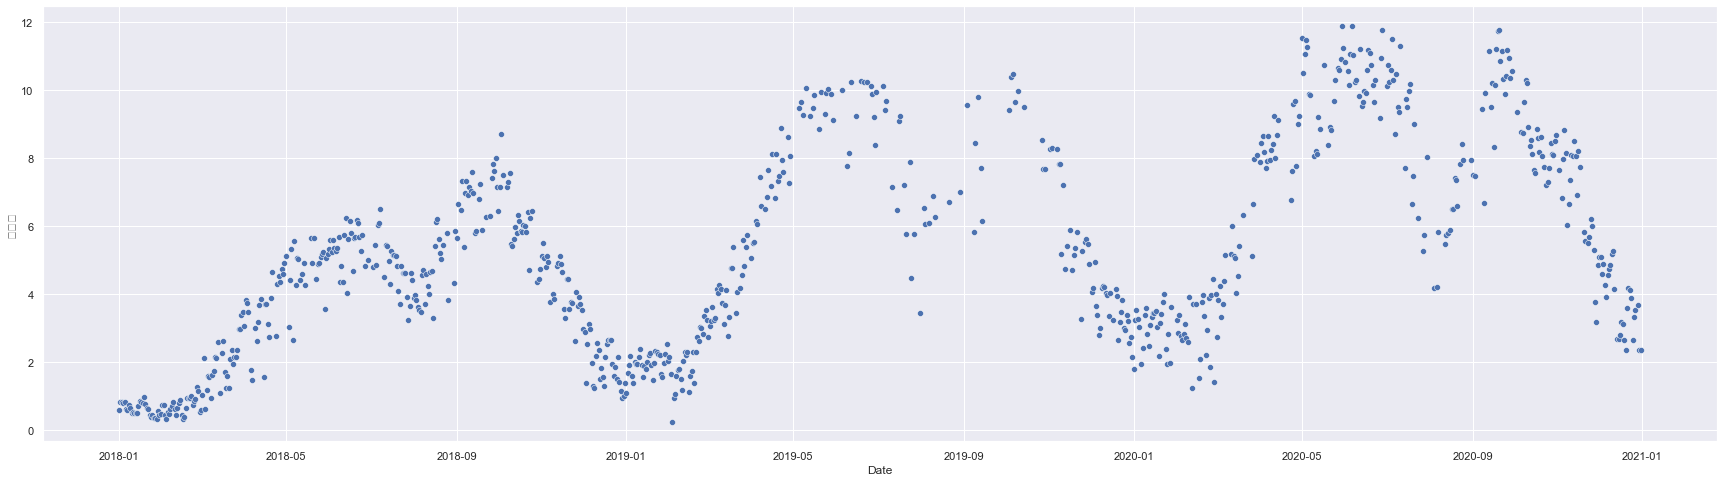

동대문구


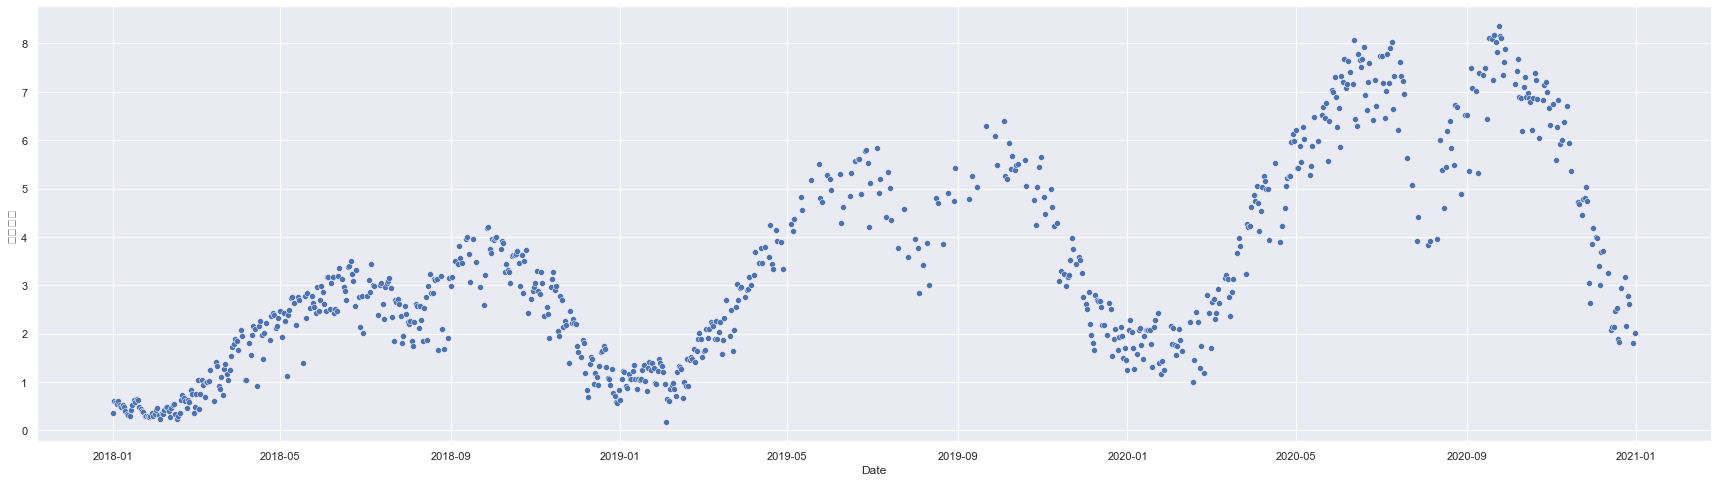

성동구


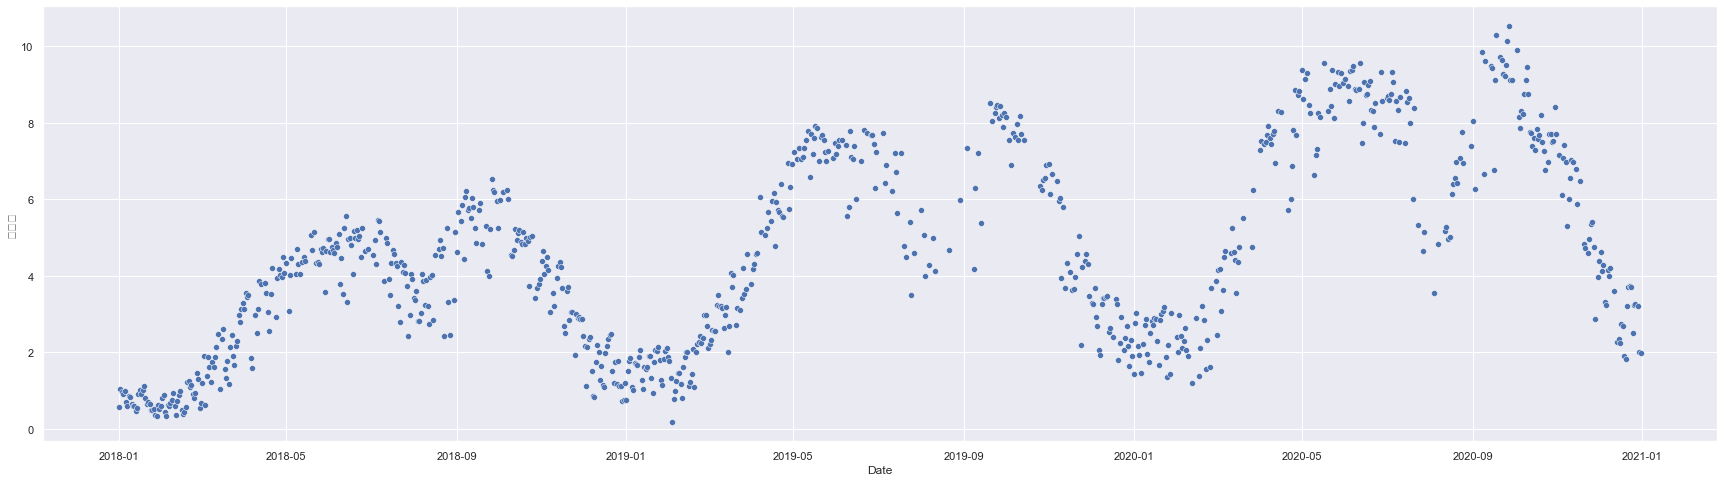

중랑구


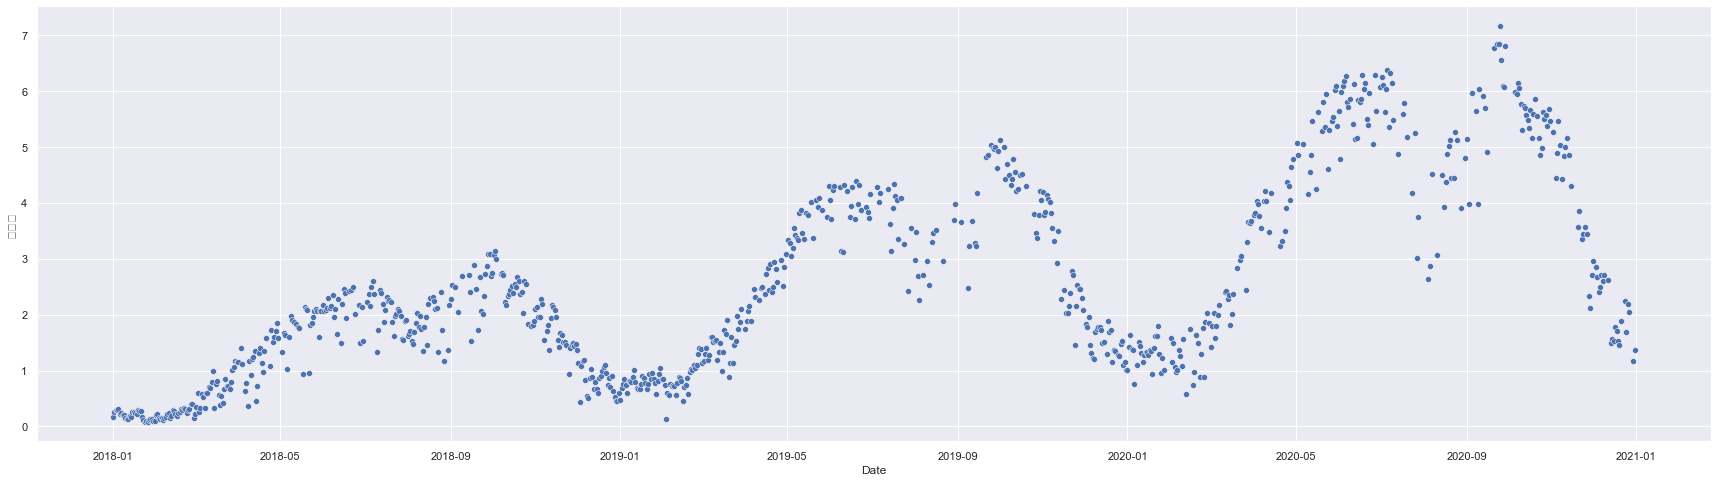

In [90]:
dates = pd.date_range('2018-1-1','2020-12-31')
merge = pd.DataFrame({
    'Date' : dates,
    '광진구' : pred_gj.fact,
    '동대문구' : pred_ddm.fact,
    '성동구' : pred_sd.fact,
    '중랑구' : pred_jr.fact
})
get_view(merge, '광진구')
get_view(merge, '동대문구')
get_view(merge, '성동구')
get_view(merge, '중랑구')

In [91]:
# 결측치 처리 물론 모든 결측치가 처리되는 것은 아님.
gj = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['광진구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
ddm = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['동대문구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
sd = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['성동구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
jr = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['중랑구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})

In [92]:
# 다시 아래쪽 이상치 제거 및 처리
# 이때 interval_width는 0.9로 설정하였음

In [93]:
pred_gj = fit_predict_model(gj, interval_width = 0.9)
pred_gj = detect_anomalies_low(pred_gj)


pred_ddm = fit_predict_model(ddm, interval_width = 0.9)
pred_ddm = detect_anomalies_low(pred_ddm)

pred_sd = fit_predict_model(sd, interval_width = 0.9)
pred_sd = detect_anomalies_low(pred_sd)

pred_jr = fit_predict_model(jr, interval_width = 0.9)
pred_jr = detect_anomalies_low(pred_jr)

15:16:25 - cmdstanpy - INFO - Chain [1] start processing
15:16:25 - cmdstanpy - INFO - Chain [1] done processing
15:16:26 - cmdstanpy - INFO - Chain [1] start processing
15:16:26 - cmdstanpy - INFO - Chain [1] done processing
15:16:27 - cmdstanpy - INFO - Chain [1] start processing
15:16:27 - cmdstanpy - INFO - Chain [1] done processing
15:16:28 - cmdstanpy - INFO - Chain [1] start processing
15:16:28 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
gj_anomaly = pred_gj.anomaly == 1
ddm_anomaly = pred_ddm.anomaly == 1
sd_anomaly = pred_sd.anomaly == 1
jr_anomaly = pred_jr.anomaly == 1

print(sum(gj_anomaly), sum(ddm_anomaly), sum(sd_anomaly), sum(jr_anomaly))

pred_gj.iloc[gj_anomaly, 5] = np.nan
pred_ddm.iloc[ddm_anomaly, 5] = np.nan
pred_sd.iloc[sd_anomaly, 5] = np.nan
pred_jr.iloc[jr_anomaly, 5] = np.nan

65 84 72 54


광진구


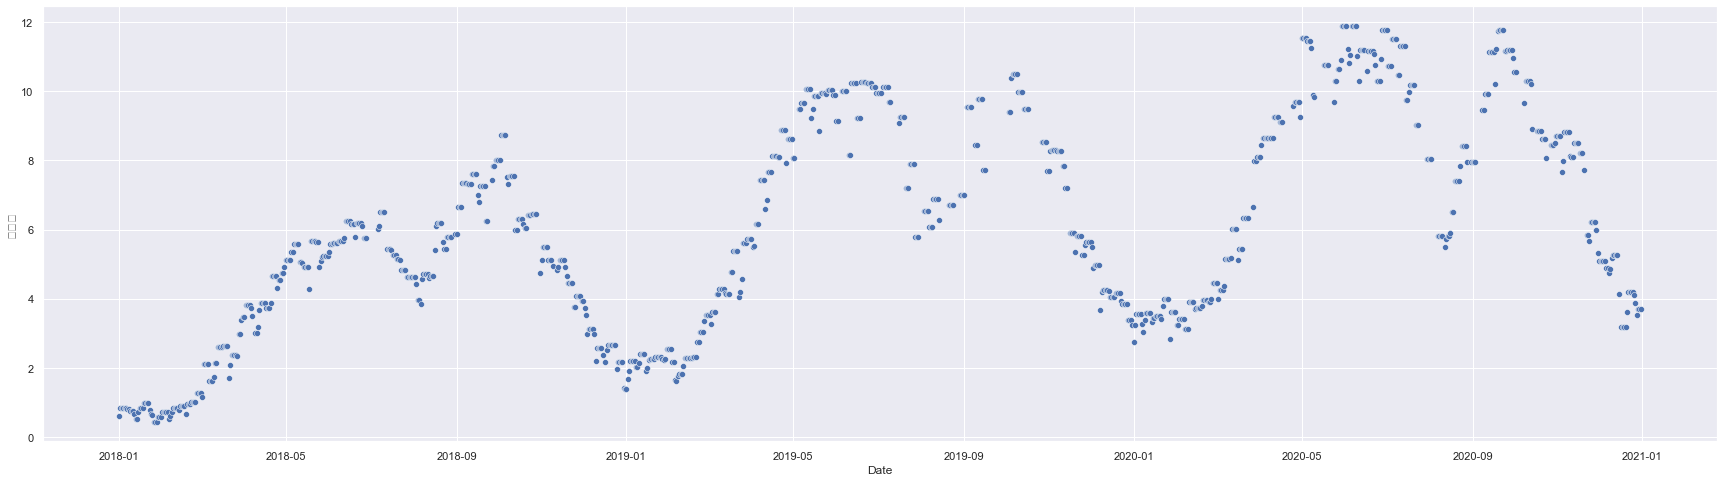

동대문구


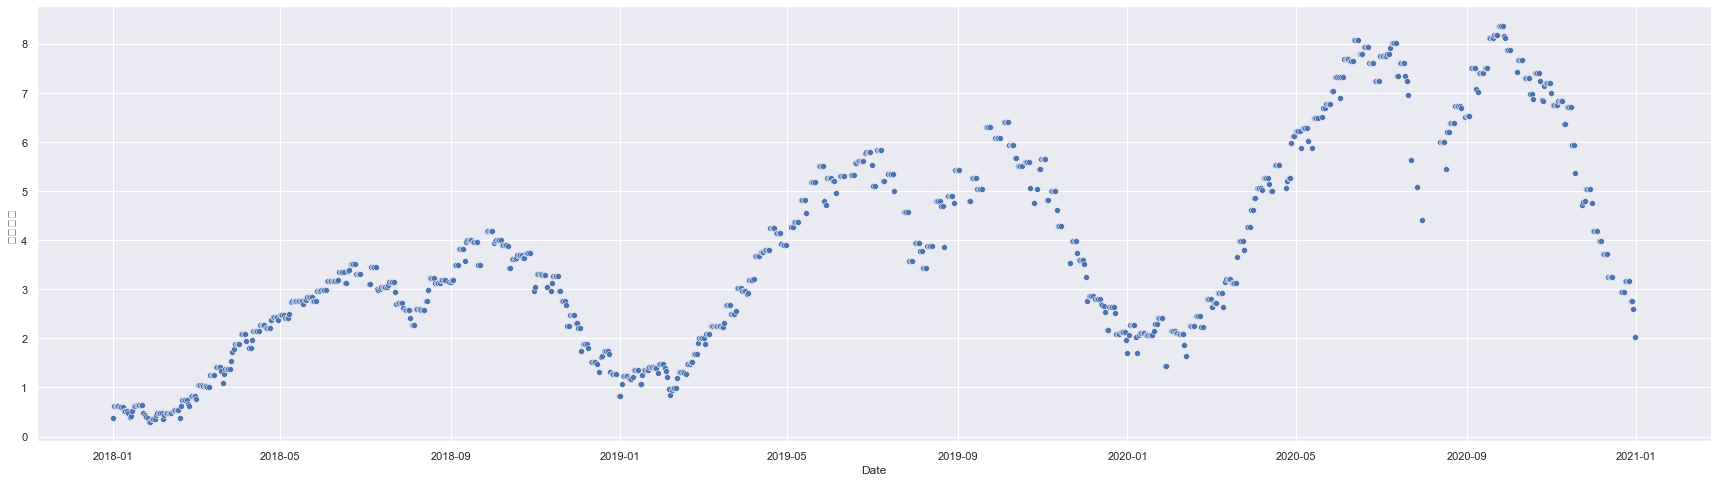

성동구


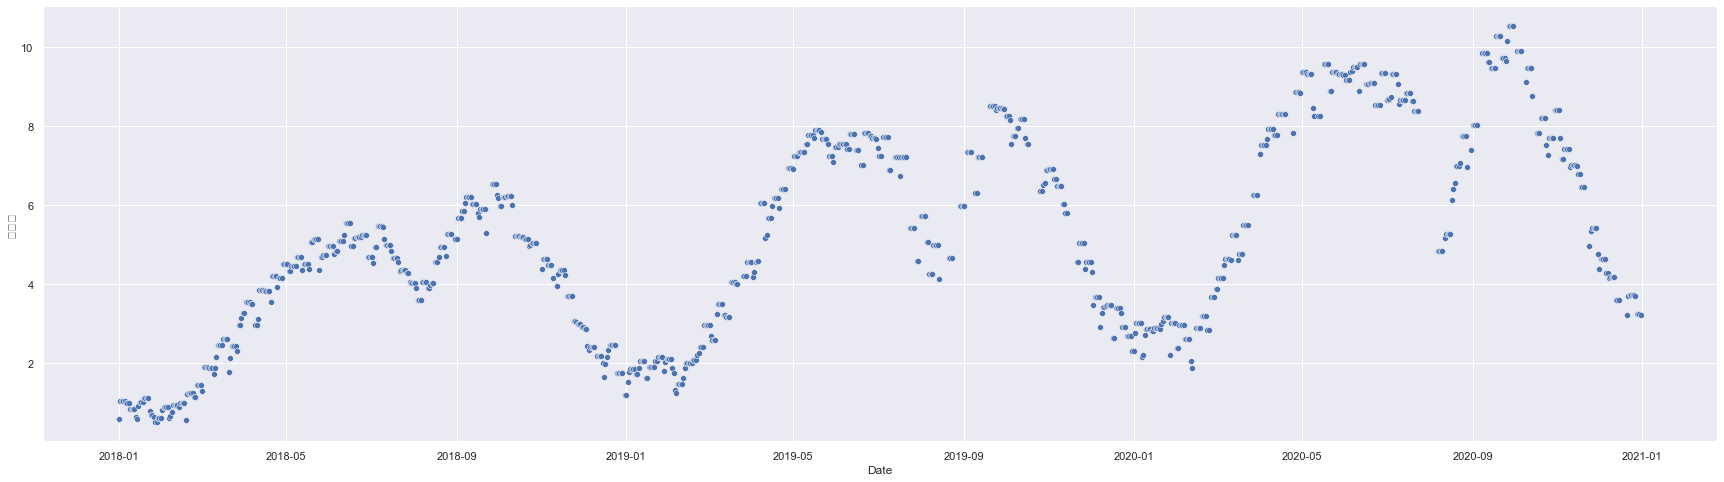

중랑구


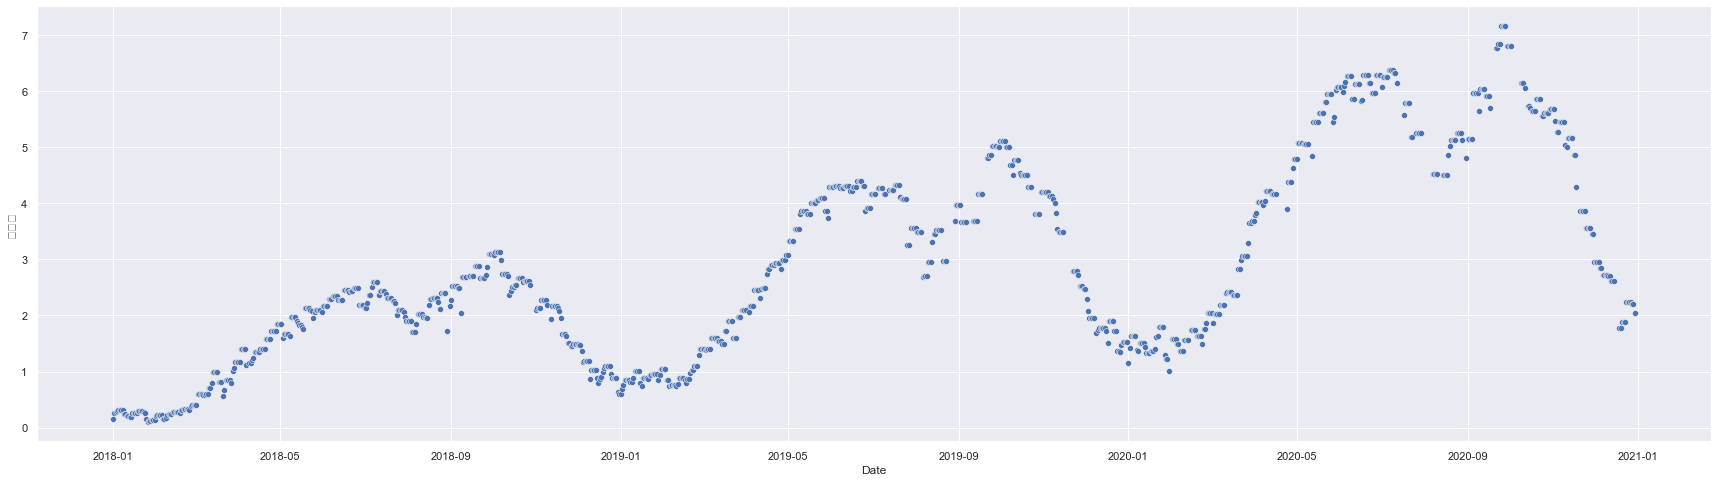

In [95]:
dates = pd.date_range('2018-1-1','2020-12-31')
merge = pd.DataFrame({
    'Date' : dates,
    '광진구' : pred_gj.fact,
    '동대문구' : pred_ddm.fact,
    '성동구' : pred_sd.fact,
    '중랑구' : pred_jr.fact
})

get_view(merge, '광진구')
get_view(merge, '동대문구')
get_view(merge, '성동구')
get_view(merge, '중랑구')

In [96]:
# rolling max를 이용해 smoothing
gj = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['광진구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
ddm = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['동대문구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
sd = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['성동구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
jr = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['중랑구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})

In [97]:
gj_model = Prophet(
    yearly_seasonality=2,
                     seasonality_mode='multiplicative', changepoint_range = 0.8)
ddm_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
sd_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
jr_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
# 모델 학습
gj_model.fit(gj)
ddm_model.fit(ddm)
sd_model.fit(sd)
jr_model.fit(jr)

15:16:31 - cmdstanpy - INFO - Chain [1] start processing
15:16:31 - cmdstanpy - INFO - Chain [1] done processing
15:16:31 - cmdstanpy - INFO - Chain [1] start processing
15:16:31 - cmdstanpy - INFO - Chain [1] done processing
15:16:31 - cmdstanpy - INFO - Chain [1] start processing
15:16:31 - cmdstanpy - INFO - Chain [1] done processing
15:16:31 - cmdstanpy - INFO - Chain [1] start processing
15:16:31 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
dates = pd.date_range('2018-1-1','2021-12-31')
last_1year = pd.DataFrame(dates, columns = ['ds'])

In [99]:
gj_forecast = gj_model.predict(last_1year)
ddm_forecast = ddm_model.predict(last_1year)
fd_orecast = sd_model.predict(last_1year)
jr_forecast = jr_model.predict(last_1year)

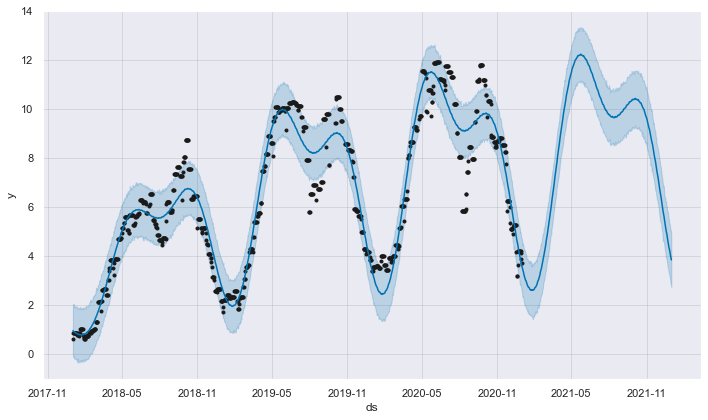

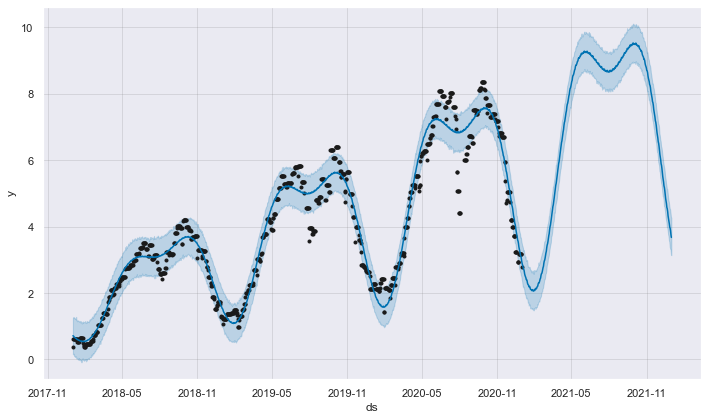

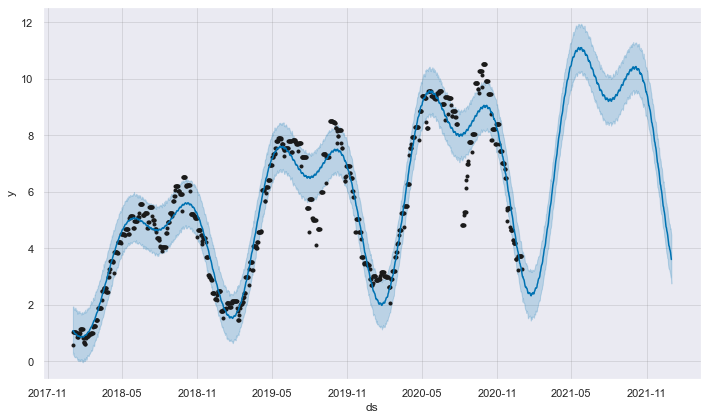

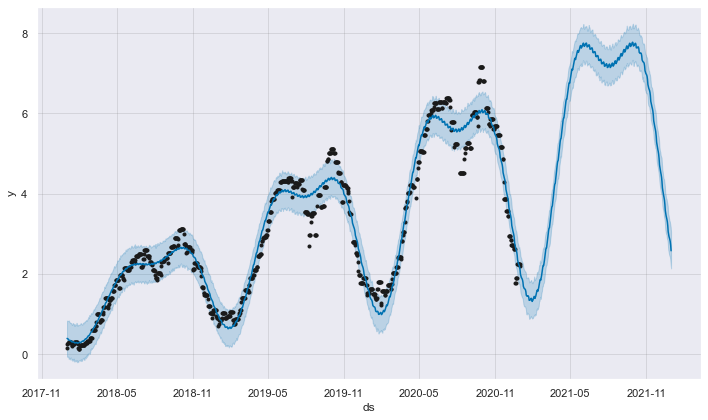

In [100]:
gj_model.plot(gj_forecast)
ddm_model.plot(ddm_forecast)
sd_model.plot(fd_orecast)
jr_model.plot(jr_forecast)
pyplot.show()

In [101]:
val_dates = pd.date_range('2021-1-1','2021-12-31')
after_1year = pd.DataFrame(val_dates, columns = ['ds'])

In [102]:
gj_forecast = gj_model.predict(after_1year)
ddm_forecast = ddm_model.predict(after_1year)
sd_forecast = sd_model.predict(after_1year)
jr_forecast = jr_model.predict(after_1year)

### Validation

In [103]:
def compute_validation_mae(start, end):
    train_df = pd.read_csv('./train.csv')
    train_df['Date'] = train_df['일시'].astype(str)
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    train_df = train_df.drop(['일시'], axis = 'columns')
    val_dates = pd.date_range(start,end)
    val_dates = pd.DataFrame(val_dates, columns = ['ds'])
    val_df = train_df[(train_df['Date'] <= end) & (train_df['Date']>=start)].copy()
    
    gj_mae = mean_absolute_error(val_df["광진구"], gj_model.predict(val_dates)['yhat'])
    ddm_mae = mean_absolute_error(val_df["동대문구"], ddm_model.predict(val_dates)['yhat'])
    sd_mae = mean_absolute_error(val_df["성동구"], sd_model.predict(val_dates)['yhat'])
    jr_mae = mean_absolute_error(val_df["중랑구"], jr_model.predict(val_dates)['yhat'])
    
    return np.array([gj_mae, ddm_mae, sd_mae, jr_mae]).mean()

In [104]:
compute_validation_mae(start = '2021-01-01', end = '2021-12-31')

1.579696526510826

#### 21년도 데이터 validation set, 18~20년도 train set 
#### 검증 결과 1.5797, prophet 라이브러리 특성상 변동성이 있음.


### 전체 데이터를 train하고 최종 model fitting 

In [106]:
train_df = pd.read_csv('./train.csv')
train_df['Date'] = train_df['일시'].astype(str)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df.drop(['일시'], axis = 'columns')

In [107]:
gj = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['광진구']
})
ddm = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['동대문구']
})
sd = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['성동구']
})
jr = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['중랑구']
})

In [108]:
pred_gj = fit_predict_model(gj, interval_width = 0.7)
pred_gj = detect_anomalies_low(pred_gj)

pred_ddm = fit_predict_model(ddm, interval_width = 0.7)
pred_ddm = detect_anomalies_low(pred_ddm)

pred_sd = fit_predict_model(sd, interval_width = 0.7)
pred_sd = detect_anomalies_low(pred_sd)

pred_jr = fit_predict_model(jr, interval_width = 0.7)
pred_jr = detect_anomalies_low(pred_jr)

15:17:45 - cmdstanpy - INFO - Chain [1] start processing
15:17:45 - cmdstanpy - INFO - Chain [1] done processing
15:17:46 - cmdstanpy - INFO - Chain [1] start processing
15:17:46 - cmdstanpy - INFO - Chain [1] done processing
15:17:47 - cmdstanpy - INFO - Chain [1] start processing
15:17:47 - cmdstanpy - INFO - Chain [1] done processing
15:17:48 - cmdstanpy - INFO - Chain [1] start processing
15:17:48 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
# 이상치 수 확인
gj_anomaly = pred_gj.anomaly == 1
ddm_anomaly = pred_ddm.anomaly == 1
sd_anomaly = pred_sd.anomaly == 1
jr_anomaly = pred_jr.anomaly == 1

print(sum(gj_anomaly), sum(ddm_anomaly), sum(sd_anomaly), sum(jr_anomaly))

# 이상치는 결측치로 바꿈.
pred_gj.iloc[gj_anomaly, 5] = np.nan
pred_ddm.iloc[ddm_anomaly, 5] = np.nan
pred_sd.iloc[sd_anomaly, 5] = np.nan
pred_jr.iloc[jr_anomaly, 5] = np.nan

174 167 172 159


In [110]:
dates = pd.date_range('2018-1-1','2021-12-31')
merge = pd.DataFrame({
    'Date' : dates,
    '광진구' : pred_gj.fact,
    '동대문구' : pred_ddm.fact,
    '성동구' : pred_sd.fact,
    '중랑구' : pred_jr.fact
})

gj1 = pd.DataFrame({
    'ds' : pred_gj['ds'],
    'y' : pred_gj['fact']
})
ddm1 = pd.DataFrame({
    'ds' : pred_ddm['ds'],
    'y' : pred_ddm['fact']
})
sd1 = pd.DataFrame({
    'ds' : pred_sd['ds'],
    'y' : pred_sd['fact']
})
jr1 = pd.DataFrame({
    'ds' : pred_jr['ds'],
    'y' : pred_jr['fact']
})


gj_model_ = Prophet(
    yearly_seasonality=2,
                    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)
ddm_model_ = Prophet(
    yearly_seasonality=2,
                     seasonality_mode='multiplicative', 
                     changepoint_range = 0.2, interval_width = 0.8)
sd_model_ = Prophet(
    yearly_seasonality=2,
    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)
jr_model_ = Prophet(
    yearly_seasonality=2,
    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)


In [111]:
# 모델 학습
gj_model_.fit(gj1)
ddm_model_.fit(ddm1)
sd_model_.fit(sd1)
jr_model_.fit(jr1)


15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
pred_gj = fit_predict_model(gj1, interval_width = 0.7)
pred_gj = detect_anomalies_up(pred_gj)

pred_ddm = fit_predict_model(ddm1, interval_width = .7)
pred_ddm = detect_anomalies_up(pred_ddm)

pred_sd = fit_predict_model(sd1, interval_width = .7)
pred_sd = detect_anomalies_up(pred_sd)

pred_jr = fit_predict_model(jr1, interval_width = .7)
pred_jr = detect_anomalies_up(pred_jr)

gj_anomaly = pred_gj.anomaly == 1
ddm_anomaly = pred_ddm.anomaly == 1
sd_anomaly = pred_sd.anomaly == 1
jr_anomaly = pred_jr.anomaly == 1

print(sum(gj_anomaly), sum(ddm_anomaly), sum(sd_anomaly), sum(jr_anomaly))

pred_gj.iloc[gj_anomaly, 5] = np.nan
pred_ddm.iloc[ddm_anomaly, 5] = np.nan
pred_sd.iloc[sd_anomaly, 5] = np.nan
pred_jr.iloc[jr_anomaly, 5] = np.nan

15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:51 - cmdstanpy - INFO - Chain [1] start processing
15:17:51 - cmdstanpy - INFO - Chain [1] done processing
15:17:52 - cmdstanpy - INFO - Chain [1] start processing
15:17:52 - cmdstanpy - INFO - Chain [1] done processing
15:17:53 - cmdstanpy - INFO - Chain [1] start processing
15:17:54 - cmdstanpy - INFO - Chain [1] done processing


202 190 168 181


In [113]:

dates = pd.date_range('2018-1-1','2021-12-31')
merge = pd.DataFrame({
    'Date' : dates,
    '광진구' : pred_gj.fact,
    '동대문구' : pred_ddm.fact,
    '성동구' : pred_sd.fact,
    '중랑구' : pred_jr.fact
})

# rolling max를 이용해 smoothing
gj = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['광진구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
ddm = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['동대문구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
sd = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['성동구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
jr = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['중랑구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})


In [114]:
pred_gj = fit_predict_model(gj, interval_width = 0.9)
pred_gj = detect_anomalies_low(pred_gj)


pred_ddm = fit_predict_model(ddm, interval_width = 0.9)
pred_ddm = detect_anomalies_low(pred_ddm)

pred_sd = fit_predict_model(sd, interval_width = 0.9)
pred_sd = detect_anomalies_low(pred_sd)

pred_jr = fit_predict_model(jr, interval_width = 0.9)
pred_jr = detect_anomalies_low(pred_jr)

gj_anomaly = pred_gj.anomaly == 1
ddm_anomaly = pred_ddm.anomaly == 1
sd_anomaly = pred_sd.anomaly == 1
jr_anomaly = pred_jr.anomaly == 1

print(sum(gj_anomaly), sum(ddm_anomaly), sum(sd_anomaly), sum(jr_anomaly))

pred_gj.iloc[gj_anomaly, 5] = np.nan
pred_ddm.iloc[ddm_anomaly, 5] = np.nan
pred_sd.iloc[sd_anomaly, 5] = np.nan
pred_jr.iloc[jr_anomaly, 5] = np.nan

15:17:55 - cmdstanpy - INFO - Chain [1] start processing
15:17:55 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:57 - cmdstanpy - INFO - Chain [1] start processing
15:17:58 - cmdstanpy - INFO - Chain [1] done processing
15:17:58 - cmdstanpy - INFO - Chain [1] start processing
15:17:59 - cmdstanpy - INFO - Chain [1] done processing


90 103 103 92


In [115]:

dates = pd.date_range('2018-1-1','2021-12-31')
merge = pd.DataFrame({
    'Date' : dates,
    '광진구' : pred_gj.fact,
    '동대문구' : pred_ddm.fact,
    '성동구' : pred_sd.fact,
    '중랑구' : pred_jr.fact
})
# rolling max를 이용해 smoothing
gj = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['광진구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
ddm = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['동대문구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
sd = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['성동구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
jr = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['중랑구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})

gj_model = Prophet(
    yearly_seasonality=2,
                     seasonality_mode='multiplicative', changepoint_range = 0.8)
ddm_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
sd_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
jr_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
# 모델 학습
gj_model.fit(gj)
ddm_model.fit(ddm)
sd_model.fit(sd)
jr_model.fit(jr)

15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:00 - cmdstanpy - INFO - Chain [1] done processing
15:18:00 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
dates = pd.date_range('2018-1-1','2022-11-30')
last_1year = pd.DataFrame(dates, columns = ['ds'])

gj_forecast = gj_model.predict(last_1year)
ddm_forecast = ddm_model.predict(last_1year)
fd_orecast = sd_model.predict(last_1year)
jr_forecast = jr_model.predict(last_1year)

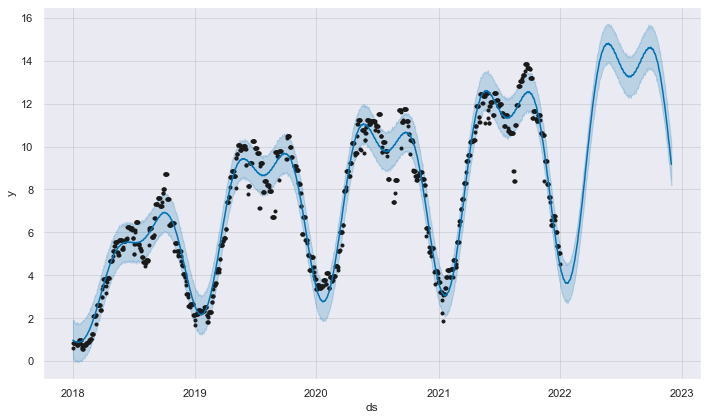

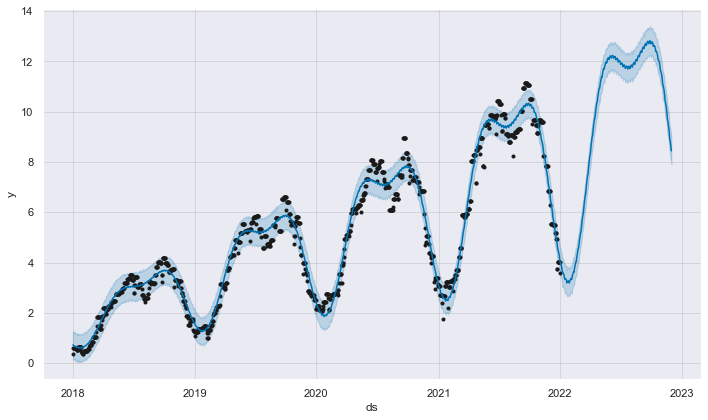

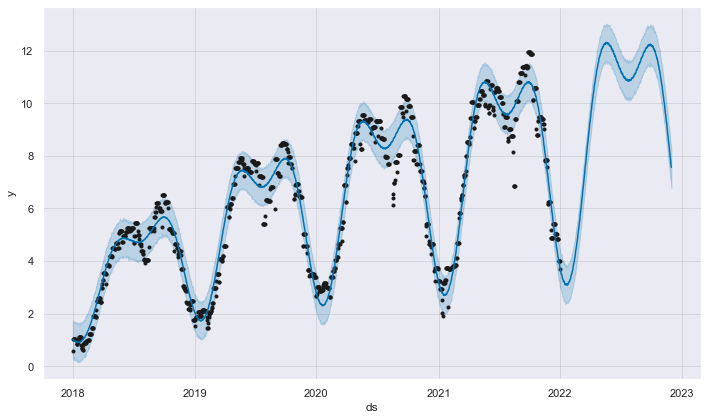

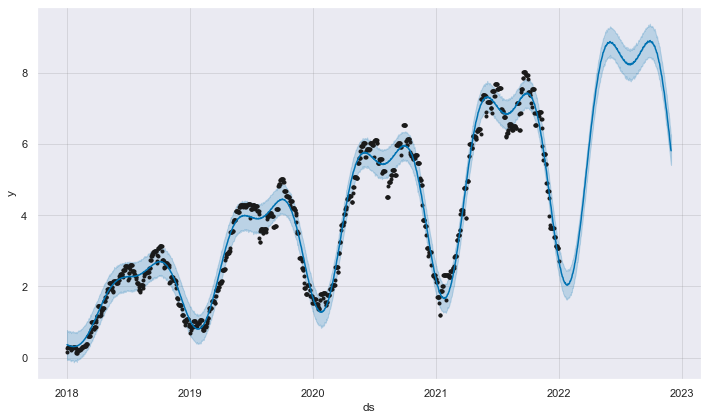

In [117]:
gj_model.plot(gj_forecast)
ddm_model.plot(ddm_forecast)
sd_model.plot(fd_orecast)
jr_model.plot(jr_forecast)
pyplot.show()

In [118]:
test_dates = pd.date_range('2022-1-1','2022-11-30')
after_1year = pd.DataFrame(test_dates, columns = ['ds'])

gj_forecast = gj_model.predict(after_1year)
ddm_forecast = ddm_model.predict(after_1year)
sd_forecast = sd_model.predict(after_1year)
jr_forecast = jr_model.predict(after_1year)

In [119]:
# 최종 제출 파일 만들기
submit = pd.read_csv('./sample_submission.csv')
submit['광진구'] = gj_forecast['yhat'].round(3)
submit['동대문구'] = ddm_forecast['yhat'].round(3)
submit['성동구'] = sd_forecast['yhat'].round(3)
submit['중랑구'] = jr_forecast['yhat'].round(3)

submit.to_csv('./b612.csv', index=False)